In [7]:
%matplotlib notebook
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

Diffusion occurs in a wide variety of materials during processing.  For example, diffusion is used to dope semiconductors to fabricate devices.  This process is called diffusion doping.  The example below illustrates how a diode can be fabricated through this process. 

A $7~\mathrm{\mu m}$ thick B-doped (p-type) Si wafer is annealed at $950~\mathrm{{}^\circ C}$ while in equilibrium with a gas containing P vapor (donor).  The concentration of B in the wafer is $2\times 10^{17} / \mathrm{cm^3}$.  P diffusivity in this system at this condition is $D\approx 10^{-14}~\mathrm{cm^2/s}$.  Assume that the concentration of P at the surface in this case is $10^{21}/\mathrm{cm^3}$.  To fabricate a device with a junction at approximately $1~\mathrm{\mu m}$ from the surface, one would like to match the P and B concentrations at a depth of $1~\mathrm{\mu m}$.  Using the following analytical formula determine how much time it will take for the concentration of P at a distance $x = 1~\mathrm{\mu m}$ from the surface to be equal to the concentration of B. 

$$C(x,t) = C_\text{surface}\left[1 - \mathrm{erf}\left(\frac{x}{2\sqrt{D t}}\right)\right]$$

Note that the $\mathrm{erf}$ function can be evaluated using SciPy (you can also consider using the complementary error function, $\mathrm{erfc}$, which is one minus the error function).

In [34]:
from scipy.special import erf
from fipy.tools.numerix import sqrt

In [3]:
import fipy as fp

NOTE: 
 - Distances are in micrometers
 - Diffusion coefficient DP is in $\mathrm{\mu m}^2/s$
 - Times are in seconds

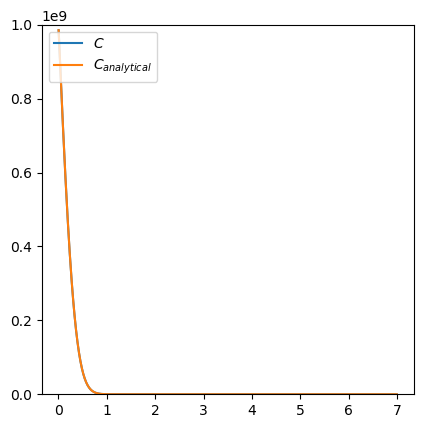

In [32]:
DP = 1.0e-6 # Diffusion coefficient (mum^2 / s)
cP = 1.0e9  # Surface concentration of phosphorus (mum^-3)

OutputDist = 1.0    # Distance at which we will output concentration (mum)
ThickM  = 7.0       # thickness of wafer (mum)
gridThickM = 1.0e-2 # grid size (mum)

nx = int(ThickM/gridThickM) # number of grid points perpendicular to surface

FinalTime = 36000 # total amount of time simulated (s)
dt = 10.0         # Time step (s)

mesh = fp.Grid1D(dx=gridThickM, nx=nx)

C = fp.CellVariable(mesh=mesh, name="$C$", value=0.0, hasOld=True)
Canalytical = fp.CellVariable(mesh=mesh, name="$C_{analytical}$")

x, = mesh.cellCenters
Canalytical.setValue(cP * (1 - erf(x / (2 * sqrt(DP * FinalTime)))))

viewer = fp.Viewer(vars=(C, Canalytical), datamin=0.0, datamax=cP)
viewer.plot()

C.constrain(cP, where=mesh.facesLeft)

## CORE OF THE CODE IS THE NEXT EQUATION
eq1 = fp.TransientTerm() == fp.DiffusionTerm(DP)
t = 0
print "dt=", dt
print "D_P=", DP
results = []
while t <= FinalTime:
    t=t+dt
    C.updateOld()
    eq1.solve(C, dt=dt)
    if t % 1800 == 0:
        results.append([t, C([[OutputDist]],order=1)[0]])
        # In a plain Python script, we would write
        #   viewer.plot()
        # but that doesn't work in a Jupyter notebook
        clear_output(wait=True)
        display(viewer)

In [16]:
print results

[[1800.0, 1.1137340912067912e-33], [3600.0, 1.8191567499831175e-18], [5400.0, 3.108709418442406e-11], [7200.0, 4.7024278655977544e-07], [9000.0, 0.0002353980978428567], [10800.0, 0.017780744712976592], [12600.0, 0.42517270241876515], [14400.0, 4.810071046515651], [16200.0, 32.583473040692866], [18000.0, 153.04056758896795], [19800.0, 548.5613756776045], [21600.0, 1601.707890467601], [23400.0, 3988.4238152070257], [25200.0, 8755.564115711346], [27000.0, 17366.047599524663], [28800.0, 31704.40614896076], [30600.0, 54044.57536280242], [32400.0, 86987.83009420583], [34200.0, 133381.38054587838], [36000.0, 196228.07418073423]]


In [19]:
results = fp.numerix.array(results)

In [21]:
plt.plot(results[..., 0], results[..., 1])

In [22]:
plt.show()

<IPython.core.display.Javascript object>


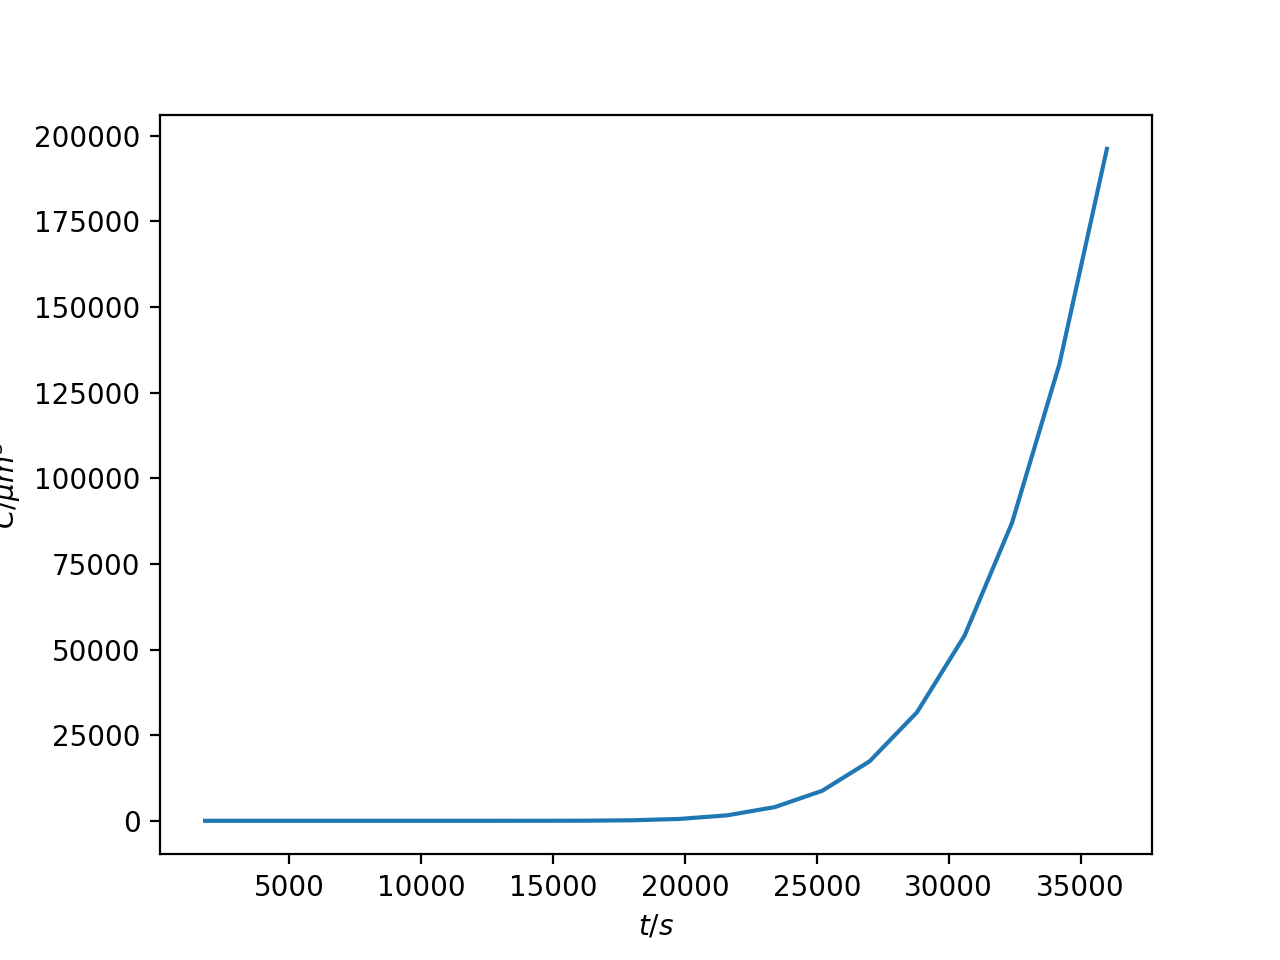

Text(0,0.5,'$C / \\mu m^3$')

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(results[..., 0], results[..., 1])
ax.set_xlabel("$t / s$")
ax.set_ylabel(r"$C / \mu m^3$")